**Import Libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [5]:
ts = data.traffic_volume['2017-09-29':'2018-09-29']

In [6]:
ts.head()

date_time
2017-09-29 00:00:00    751
2017-09-29 01:00:00    432
2017-09-29 02:00:00    310
2017-09-29 03:00:00    348
2017-09-29 04:00:00    860
Name: traffic_volume, dtype: int64

**Train/test Split**

In [7]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [8]:
len(ts_train), len(ts_test)

(9658, 968)

**Stationnarity**

In [9]:
from statsmodels.tsa.stattools import adfuller
window = 24*7
cutoff = 0.05
def test_stationarity(timeseries, window = window, cutoff = cutoff):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(30, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 24 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

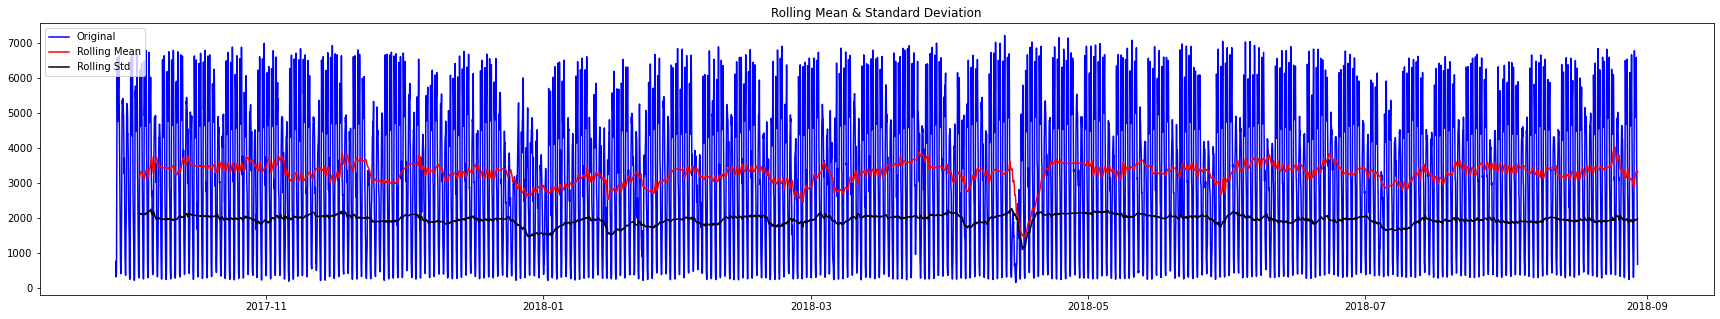

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.806529e+01
p-value                        2.614120e-30
#Lags Used                     2.400000e+01
Number of Observations Used    9.633000e+03
Critical Value (1%)           -3.431029e+00
Critical Value (5%)           -2.861840e+00
Critical Value (10%)          -2.566930e+00
dtype: float64


In [10]:
test_stationarity(ts_train)

**Building a model**

In [11]:
# ACF and PACF plots
lag = 24
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

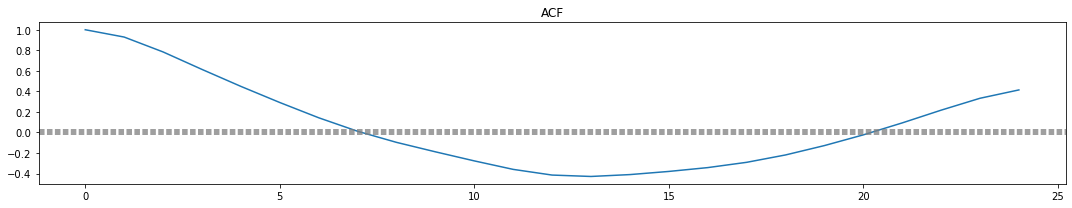

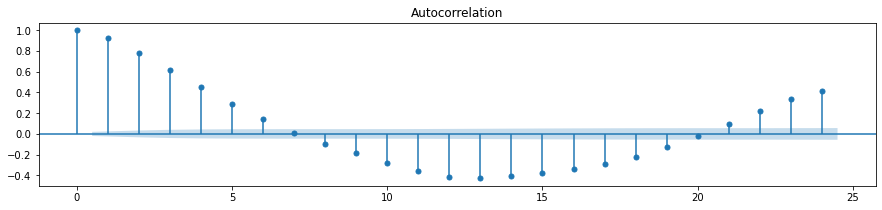

In [12]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train, ax=plt.gca(),lags=lag)
plt.show()

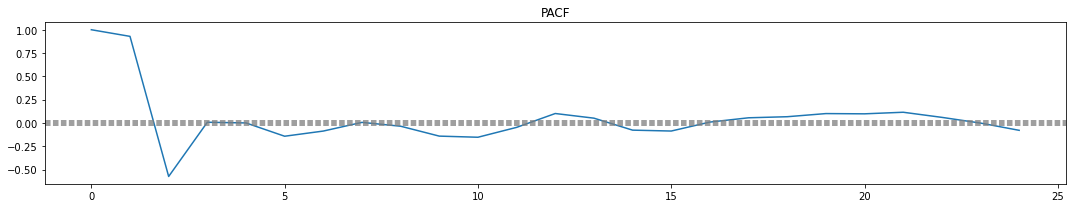

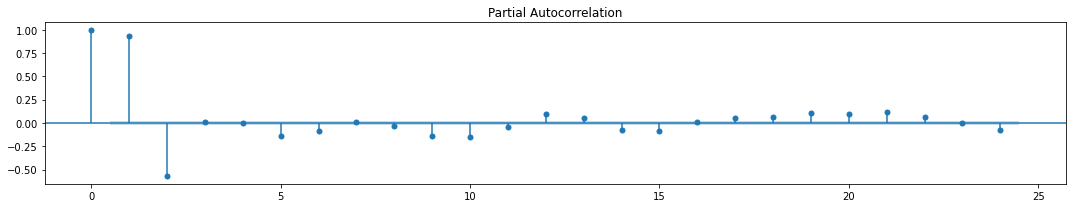

In [13]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [14]:
p=2
q=6
d=0

### ARIMA model

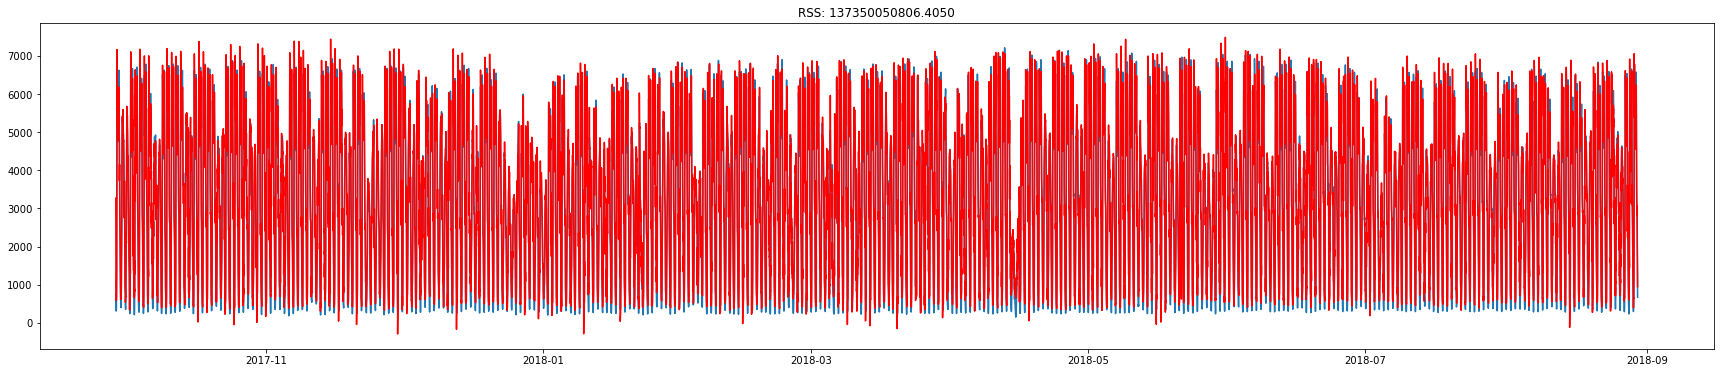

In [21]:
# ARIMA
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [22]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 9658
Model:                     ARMA(2, 6)   Log Likelihood              -75202.874
Method:                       css-mle   S.D. of innovations            582.582
Date:                Wed, 09 Mar 2022   AIC                         150425.748
Time:                        11:26:11   BIC                         150497.504
Sample:                             0   HQIC                        150450.079
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3271.8815     34.266     95.486      0.000    3204.722    3339.041
ar.L1.traffic_volume     1.8991      0.005    411.975      0.000       1.890       1.908
ar.L2.traffic_volume    -0.9590      0.005   -197.328      0.000      -0.969      -0.950
ma.L1.traffic_volume    -0.4846      0.011    -42.457      0.000      -0.507      -0.462
ma.L2.traffic_volume    -0.2909      0.012    -24.949      0.000      -0.314      -0.268
ma.L3.traffic_volume    -0.2445      0.012    -21.105      0.000      -0.267      -0.222
ma.L4.traffic_volume     0.0212      0.012      1.730      0.084      -0.003       0.045
ma.L5.traffic_volume     0.1757      0.012     15.237      0.000       0.153       0.198
ma.L6.traffic_volume     0.1695      0.012     14.116      0.000       0.146       0.193
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9901           -0.2498j            1.0211           -0.0393
AR.2            0.9901           +0.2498j            1.0211            0.0393
MA.1            1.0464           -0.3094j            1.0912           -0.0458
MA.2            1.0464           +0.3094j            1.0912            0.0458
MA.3           -0.1789           -1.3840j            1.3955           -0.2705
MA.4           -0.1789           +1.3840j            1.3955            0.2705
MA.5           -1.3858           -0.7900j            1.5952           -0.4175
MA.6           -1.3858           +0.7900j            1.5952            0.4175
-----------------------------------------------------------------------------
"""

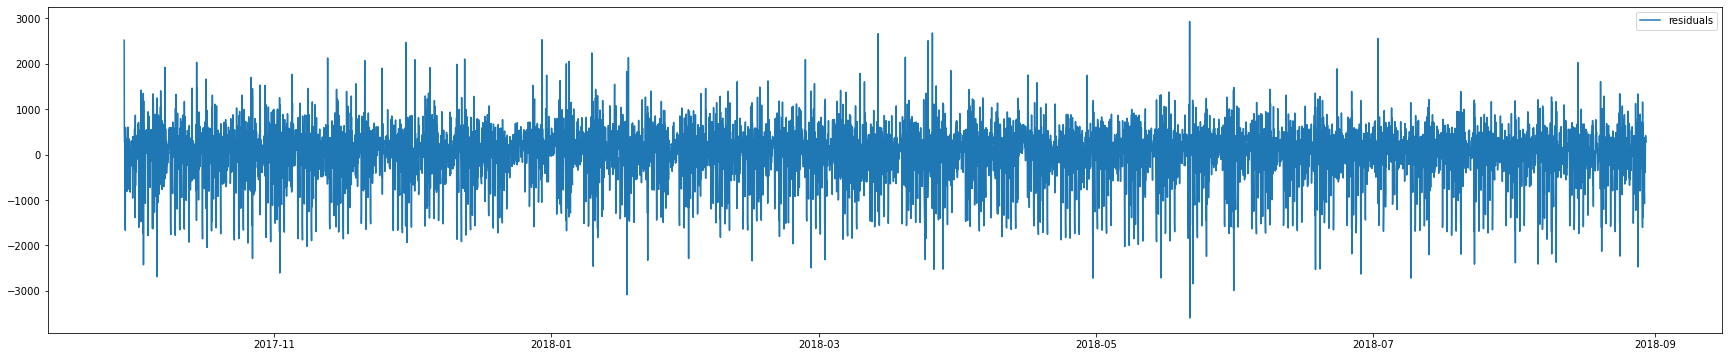

In [23]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## Test ARIMA on testset

In [27]:
def StartARIMAForecasting(Actual, p, d, q):
    model = ARIMA(Actual, order=(p, d, q))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

In [ ]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
    ActualValue =  ts_test[timepoint]
    #forcast value
    Prediction = StartARIMAForecasting(Actual, p,d,q)    
    print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=456.000000, Predicted=675.224520
Actual=326.000000, Predicted=698.175364
Actual=388.000000, Predicted=563.191372


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#Calculate Model error
'''
print('Train Mean Absolute Error:', mean_absolute_error(ts_train, ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_train, ts_train_fcst[:,0])))
print('Train Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_train, ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

In [ ]:
# zoom on lastest week
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions)[0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')